# Guide to Extracting Data w/ APIs from Google Fit


<img src='https://i.imgur.com/Oc6P36u.jpg' height="500"> 

A picture of the Google Fit Mobile Application

Google Fit is Google's version of Apple Health. It lets you track your fitness activity and health data from all of your wearable devices like Apple Watches, Samsung Galaxy Watches, Polar Smartwatches, etc. <br>

Google Fit is completely free. It also comes preloaded on Android Wear watches and can be downloaded from the Apple App and Google Play stores. <br>

We've been using the Google Fit application for the past few weeks and we will show you how to extract its data, visualize your activities and compute correlations between multiple metrics of the data. The Google Fit API allows the users to extract all kinds of data on workouts and medical health. However, for this notebook, we will be focusing on metrics of the participant's daily summary and activities such as steps, heart rate, workouts, etc.



We will be able to extract the following parameters:

Parameter Name  | Sampling Frequency 
-------------------|------------------
Sleep Duration |  Daily
Reproductive Health (Period Flow) |  Daily
[Move Minutes](https://developers.google.com/fit/datatypes/aggregate#move_minutes_summary) |  Daily
[Speed](https://developers.google.com/fit/datatypes/aggregate#speed_summary) |  Daily
Energy Expended |  Daily
Blood Glucose      |  Per Minute 
Oxygen Saturation |  Per Minute 
Steps |  Per Minute 
Blood Pressure |  Per Minute 
Body Temperature |  Per Minute
Calories Consumed |  Per Minute
Heart Rate |  Every 5 seconds 

In this guide, we sequentially cover the following five topics to extract data from the Google Fit API:

1. **Setup**<br>
   1.1 Setup and usage guidelines for the participant. <br>
2. **Authentication/Authorization**<br>
   2.1 Setup and usage guidelines for the researcher.<br>
3. **Data extraction**<br>
  3.1 Extracting Data from the Google Fit API<br>
4. **Data visualization & analysis** <br>
  4.1 Visualizing participant's Weekly Step Activity! <br>
  4.2 Visualizing participant's Weekly Heart Activity! <br>
  4.3 Visualizing participant's Detailed Heart Rate Breakdown!<br>
5. **Data Analysis** <br>
  5.1 Analyzing correlation between Heart Rate and Number of Steps! <br>
  5.2 Outlier Detection!


Before starting, note that the Google Fit access token necessary to extract data only lasts for 1 hour. Thus, the researcher should fetch the data as soon as the participant provides the token.


#1. Setup
Relevant libraries are imported below

In [ ]:
pip install fsspec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests
import urllib3
import os
import json
import httplib2
import requests
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from pandas.io.json import json_normalize
import time
from datetime import datetime, timedelta, date
from apiclient.discovery import build
from oauth2client.client import OAuth2WebServerFlow, flow_from_clientsecrets
from oauth2client.file import Storage
from scipy.signal import savgol_filter
from sklearn.covariance import EllipticEnvelope
import seaborn as sns
import copy

##1.1 Setup and usage, participant:

Note: These steps are to be followed by the participants from their account to grant the researcher with the access token.

Step 1: Go to this link: https://developers.google.com/oauthplayground/

Step 2: Choose fitness API v1 in the Select & authorize APIs menu
<br>
<img src='https://i.imgur.com/odrvr9v.png' width="500" height="550"> 

Step 3: Select all the different datatypes that you the researcher wants you to grant access to and click authorize APIs. Your clinical study coordinator might have more details regarding what sorts of health data they require. <br>
<img src='https://i.imgur.com/L5PM8lB.png' width="450" height="550"> 

Step 4: Login with your account (the one the participant has connected with their Google Fit Account). <br>
<img src='https://i.imgur.com/LEY8CnQ.png' width="400" height="500"> 

Step 5: Click on ‘Continue’ 
<br>
<img src="https://i.imgur.com/RLUtPeu.png" height="500" width="300">

Step 6: Click on the exchange authorization code for tokens in Step2.
<br>
<img src="https://i.imgur.com/9KpZbJZ.png">

Step 7: Copy and paste the access token from the Google Developer Playground and paste in the box in part section **2.1**. <br>
<img src="https://i.imgur.com/Gv7PRGI.png">

#2. Authentication/Authorization
To obtain access to data, authorization is required.

Google Fit uses external devices to extract recorded activities, but it requires the participant to provide access tokens to access Google's API and read fitness data from their account.

##2.1 Setup and usage, researcher:

In [ ]:
#@title Enter the Participant's Access Token

google_access_token = 'ya29.a0AX9GBdXaNyTiM9YmEXioeS-tUAN32dQpG-VG3dRAWeJhZTIbPAm2qtEVBf3q-HSEpslo7MiNQUqs37BJ5PUCK5iVzkyjkurdhWGA_OcfypXzrQSU5AHwfT6vG2a3ap1UcpsDOEiws9xPmLii96ZsWqD_3ocDaCgYKAYISARESFQHUCsbCaIJ2jbngr-oJW3yWy0UXAw0163' #@param {type:"string"}

print('Access Token: '+google_access_token)

Access Token: ya29.a0AX9GBdXaNyTiM9YmEXioeS-tUAN32dQpG-VG3dRAWeJhZTIbPAm2qtEVBf3q-HSEpslo7MiNQUqs37BJ5PUCK5iVzkyjkurdhWGA_OcfypXzrQSU5AHwfT6vG2a3ap1UcpsDOEiws9xPmLii96ZsWqD_3ocDaCgYKAYISARESFQHUCsbCaIJ2jbngr-oJW3yWy0UXAw0163


#3. Data extraction

Data can be extracted via an [official API](https://developers.google.com/fit), which is documented [here](https://developers.google.com/fit/rest).<br><br>

We go into a bit of detail as to how this works below. This is not strictly necessary for extracting your data once, but it can be useful if you want to extend this notebook for your own usage. <br><br>

The figure below shows how data is uploaded to Google servers. Google Fit automatically syncs with your fitness devices and Apple Health to sync your data.<br>

<img src="https://i.imgur.com/1O0Mg3G.png" height="500">

The next few lines create a post request to the Google Fit API and requests your data.

To Extract Data from Google Fit, please enter a start date below. <br>

In [ ]:
#@title Enter your Start Date

year_string = '2022' #@param {type:"string"}
month_string = '05' #@param {type:"string"}
day_string = '16' #@param{type:"string"}

print('Date is: '+year_string+'/'+month_string+'/'+day_string)

Date is: 2022/05/16


Next, put in your end date.

In [ ]:
#@title Enter your Start Date

end_year_string = '2022' #@param {type:"string"}
end_month_string = '06' #@param {type:"string"}
end_day_string = '15' #@param{type:"string"}

x = datetime.now()
end_time = int(datetime(int(end_year_string), int(end_month_string), 
                         int(end_day_string)).timestamp()*1000)
start_time =int(datetime(int(year_string), int(month_string), 
                         int(day_string)).timestamp()*1000)


print('Date is: '+end_year_string+'/'+end_month_string+'/'+end_day_string)

Date is: 2022/06/15


The code below does a post request to the Google Fit API requesting your daily step data.


In [ ]:

api_url = "https://www.googleapis.com/fitness/v1/users/me/dataset:aggregate"

g_access_token = google_access_token


headers = {
  "Authorization": "Bearer {}".format(g_access_token),
  "Content-Type": "application/json;encoding=utf-8"
  }

body = {
  "aggregateBy": [{
    "dataTypeName": "com.google.step_count.delta",
    "dataSourceId": "derived:com.google.step_count.delta:com.google.android.gms:estimated_steps"
  }],
  "bucketByTime": { "durationMillis": 86400000 },
  "startTimeMillis": start_time,
  "endTimeMillis": end_time
}

response = requests.post(api_url, data=json.dumps(body), headers=headers)

In [ ]:
steps = pd.read_json(response.text)

The code below does a post request to the Google Fit API requesting your daily heart_rate data.

In [ ]:
api_url = "https://www.googleapis.com/fitness/v1/users/me/dataset:aggregate"

access_token = google_access_token


headers = {
  "Authorization": "Bearer {}".format(access_token),
  "Content-Type": "application/json;encoding=utf-8"
  }

body = {
  "aggregateBy": [{
    "dataTypeName": "com.google.heart_rate.bpm",
    "dataSourceId": "derived:com.google.heart_rate.bpm:com.google.android.gms:merge_heart_rate_bpm"  }],
  "bucketByTime": { "durationMillis": 86400000 },
  "startTimeMillis": start_time,
  "endTimeMillis": end_time
}

response_hr = requests.post(api_url, data=json.dumps(body), headers=headers)

#4. Data visualization

##4.1 Visualizing participant's Weekly Step Activity!

Let's say you were interested in knowing how many steps you take in a day. If you had an iPhone you could go onto Apple Health and check out your step count that is being approximated by just your iphone's [built-in accelerometer](https://developer.apple.com/documentation/coremotion/getting_raw_accelerometer_events). You would see your Weekly Steps chart using the following plot: <br>
<img src="https://i.imgur.com/gG8EbwJ.jpg" height="300"> <br>
Let's recreate this for the your choice of week using the data that we have fetched from the Google Api!


Below, input the desired start and end dates for the plot above.




In [ ]:
#@title Set date range for the chart above

start = "2022-05-24" #@param {type:"date"}
end = "2022-05-30" #@param {type:"date"}

Next, we will go over our start and end dates and find a list of all the dates that lie in our date range.

In [ ]:
# A Dictionary to save the list of all the dates between end and start dates
step_plot_dates= {}

# Saving the end and start dates in a date format from the inputted strings
step_plot_start_date = date(int(start.split('-')[0]),int(start.split('-')[1]),
                            int(start.split('-')[2]))
step_plot_end_date = date(int(end.split('-')[0]),int(end.split('-')[1]),
                          int(end.split('-')[2]))

# Finding the list of all dates between our start and end dates
dates = list(pd.date_range(step_plot_start_date,step_plot_end_date,freq='d'))

Now, we will create a dictionary with all the dates and step counts which will be used in creating our plots. We will also fix the dictionary keys to be in the first three letters of the day name rather than the date.

In [ ]:
# Dictionary to store the stepcount for each date
stepcount = {}

# Loop to go over each date in our list
for date_val in dates:

  # Initializing each date in our dictionary as 0
  stepcount[date_val.day_name()[:3]+" ("+
            date_val.to_pydatetime().strftime('%Y-%m-%d')+")"] = 0

  # Checking each date in the steps dataset to save stepcount
  for i in range(len(steps)):
      if(date_val.to_pydatetime().strftime('%Y-%m-%d') == datetime.fromtimestamp(int(steps.iloc[i][0]['startTimeMillis'])// 1000).strftime('%Y-%m-%d')):
        if len(steps.iloc[16].get('bucket')['dataset'][0]['point']) == 0:
          continue
        stepcount[date_val.day_name()[:3]+" ("+date_val.to_pydatetime().strftime('%Y-%m-%d')+")"] = stepcount[date_val.day_name()[:3]+" ("+date_val.to_pydatetime().strftime('%Y-%m-%d')+")"] +  steps.iloc[i].get('bucket')['dataset'][0]['point'][0]['value'][0]['intVal']

In [ ]:
stepcount

{'Tue (2022-05-24)': 14537,
 'Wed (2022-05-25)': 4613,
 'Thu (2022-05-26)': 20761,
 'Fri (2022-05-27)': 14863,
 'Sat (2022-05-28)': 16210,
 'Sun (2022-05-29)': 16099,
 'Mon (2022-05-30)': 25391}

If you look at the reference plot above, there is a header with the average statistics. In the next block, we will calculated the average values and the date range for the plot header.

In [ ]:
# Counts the average steps in our plot and stores that as a formatted text
average_steps = '{:,}'.format(int(np.mean(list(stepcount.values()))))

# Saving the plot date range in the form of a string
date_range_text = (str(step_plot_start_date.day)+' '+
step_plot_start_date.strftime("%B")[:3]+' - '+
 str(step_plot_end_date.day)+' '+step_plot_end_date.strftime("%B")[:3]+
 ' '+ step_plot_start_date.strftime("%Y"))

Now that we have our step count and the required xticks, it is finally time for us to plot our graph!

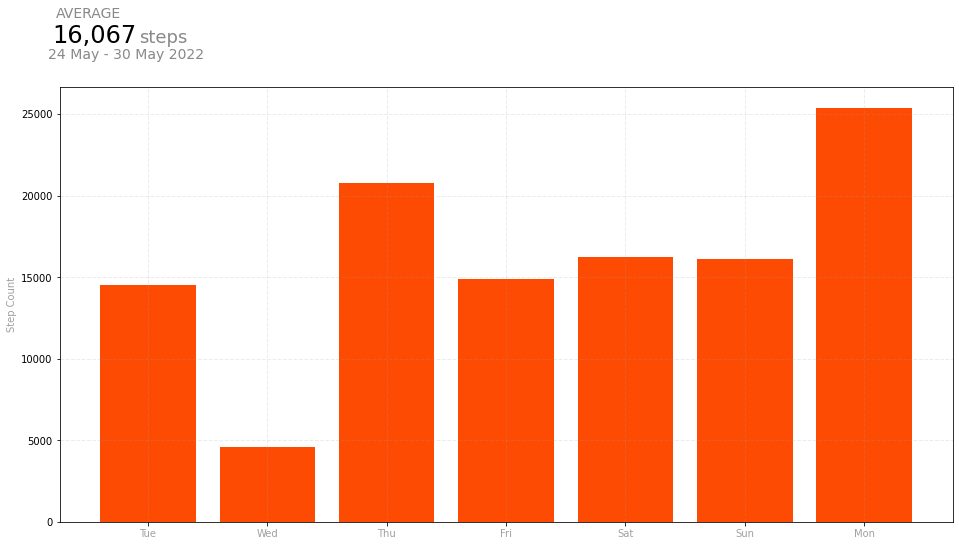

In [ ]:
# Creating the matptplotlib graph
plt1 = plt.figure(figsize=(16,8))
ax = plt1.gca()

# Adding grid lines to the chart
plt.grid(color="#a1a1a1", linestyle='--', linewidth=1, alpha = 0.2)

# Plotting our bars
plt.bar([key[:3] for key in stepcount.keys()],list(stepcount.values()),
        color="#FD4B03")

# Setting labels and titles
plt.ylabel("Step Count",color="#a1a1a1")

# Adding Step header
plt.text(0.15,1,"AVERAGE",fontsize=14,color='#89898B',
         transform=plt1.transFigure,horizontalalignment='center',
         weight='light')
plt.text(0.155,0.957,average_steps,fontsize=24,transform=plt1.transFigure,
         horizontalalignment='center')
plt.text(0.215,0.957,'steps',fontsize=18,transform=plt1.transFigure,
         horizontalalignment='center',color='#89898B')
plt.text(0.183,0.93,date_range_text,fontsize=14,color='#89898B',
        transform=plt1.transFigure, horizontalalignment='center', weight='light')


# Setting x and y ticks
plt.yticks([0,5000,10000,15000,20000,25000])
plt.xticks(color="#a1a1a1")

plt.show()

<i>Above is a plot we created ourselves!</i>

##4.2 Visualizing participant's Weekly Heart Activity!

Similar to 4.1, if you were interested in checking out your heart rate values over the week then Apple Health would show your Weekly Heart Rate chart using the following plot: <br>
<img src="https://i.imgur.com/hS9Q9uP.jpg" height="600"> <br>
Let's recreate this for the your choice of week using the data that we have fetched from the Google Api! <br>

First, we will save the data that we fetched from the Google Fit API in the form of a DataFrame for us to easily work with that data!


In [ ]:
# Saving the heart rate values in a DataFrame
heart_rate = pd.read_json(response_hr.text)
heart_rate.head()

,bucket
0,"{'startTimeMillis': '1652659200000', 'endTimeM..."
1,"{'startTimeMillis': '1652745600000', 'endTimeM..."
2,"{'startTimeMillis': '1652832000000', 'endTimeM..."
3,"{'startTimeMillis': '1652918400000', 'endTimeM..."
4,"{'startTimeMillis': '1653004800000', 'endTimeM..."


Next, we will create a dictionary to store all the required values with the dates that have to plotted!

In [ ]:
# Creating a dictionary to save all the heart rate values with the dates
heartrate_dict = {}

# Traversing through each entry in our DataFrame to save heart
# rate values for each date
for i in range(heart_rate.size-1):

  # Case when there is no data for a specific date
  if (len(heart_rate.iloc[i].get('bucket')['dataset'][0]['point'])==0):
    continue
  else:
    heartrate_dict[datetime.fromtimestamp(
    int(heart_rate.iloc[i][0]['startTimeMillis'])// 1000).strftime(
        '%Y-%m-%d')] = (
    heart_rate.iloc[i]['bucket']['dataset'][0]['point'][0]['value'][0]['fpVal'],
    heart_rate.iloc[i]['bucket']['dataset'][0]['point'][0]['value'][1]['fpVal'],
    heart_rate.iloc[i]['bucket']['dataset'][0]['point'][0]['value'][2]['fpVal'])

In [ ]:
# Creating a dictionary to save all the heart rate values with the dates between the specific end and start dates
heartrate_dict_weekly = {}

# Traversing each date for all the dates between start and end
for date_val in dates:
  # Initilizing each date with (0,0,0) 
  heartrate_dict_weekly[date_val.day_name()[:3]+" ("+
                  date_val.to_pydatetime().strftime('%Y-%m-%d')+")"] = (0,0,0)
  # Saving actual high, low and avg values for dates that have data avaliable
  for key in heartrate_dict.keys():
    if (date_val.to_pydatetime().strftime('%Y-%m-%d') == key):
      heartrate_dict_weekly[date_val.day_name()[:3]+" ("+
      date_val.to_pydatetime().strftime('%Y-%m-%d')+")"] = heartrate_dict[key]

If you look at the reference plot above, there is a header with the average statistics. In the next block, we will calculate the range values of your heart rate for the plot header.

In [ ]:
# This will help us find the low to max heart rate values for our chart header
bpm_range = str(min([i[2] for i in heartrate_dict_weekly.values()]))+' - '+ str(max([i[1] for i in heartrate_dict_weekly.values()]))
bpm_range

'48 - 164'

Next, we will use the data we collected above to plot our chart!

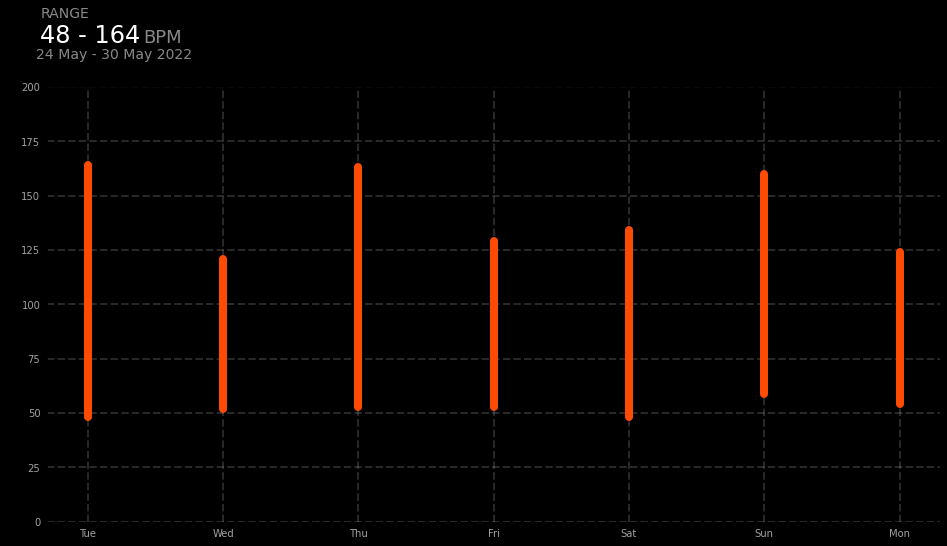

In [ ]:
# Initializing the figure
plt2 = plt.figure(figsize=(16,8),facecolor='black')
ax = plt.gca()
ax.set_facecolor('#000000')


# Plotting the values
x = [key[:3] for key in list(heartrate_dict_weekly.keys())]
y = list(heartrate_dict_weekly.values())
plt.plot((range(len(x)),range(len(x))),([i[1] for i in y], [i[2] for i in y]),
         c='#FD4B03',lw=8,solid_capstyle='round')

# Setting y limit to the chart
plt.ylim(0,200)

# Setting x and y ticks
plt.xticks(range(len(x)),x,color="#a1a1a1")
plt.yticks(color="#a1a1a1")

# Setting labels
plt.ylabel('Heart Rate')

# Creating grid lines
plt.grid(color="#a1a1a1", linestyle='--', linewidth=2, alpha = 0.25)


# Adding Heart header
plt.text(0.14,1,"RANGE",fontsize=14,color='#89898B',transform=plt2.transFigure,
         horizontalalignment='center', weight='light')
plt.text(0.1625,0.957,bpm_range,fontsize=24,transform=plt2.transFigure, 
         horizontalalignment='center', color = 'white')
plt.text(0.225,0.957,'BPM',fontsize=18,transform=plt2.transFigure, 
         horizontalalignment='center',color='#89898B')
plt.text(0.183,0.93,date_range_text,fontsize=14,color='#89898B',
         transform=plt2.transFigure, horizontalalignment='center',
         weight='light')

plt.show()

<i>Above is a plot we created ourselves!</i>

##4.3 Visualizing participant's Detailed Heart Rate Breakdown



In the vital section of the google app, one can see a detailed breakdown of their Heart Rate. <br> <br>
<img src="https://i.imgur.com/H2m2P6L.jpg" width=500> <br>

This chart showcases the daily fluctuation of the heart rate of our user on that specific date. The dark pink line showcases the average heart rate value within the interval of 15 minutes. The light pink highlight showcases the varation in that time interval. This would be a great way to visualize if there are specific times during which the heart rate changed the most. This could be a great indicator of a physical exercise. Let's try to access the data in this activity and recreate the plot above to visualize it.

Below, please enter the date for which you want to visualize the detailed heart rate breakdown.

In [ ]:
#@title Enter the Date

year_string = '2022' #@param {type:"string"}
month_string = '06' #@param {type:"string"}
day_string = '12' #@param{type:"string"}

print('Date is: '+year_string+'/'+month_string+'/'+day_string)

Date is: 2022/06/12


In [ ]:
# The next line finds the millisecond end and start timestamps for our specfic day
hr_date =int(datetime(int(year_string), int(month_string), 
                      int(day_string)).timestamp()*1000)
hr_end_date = hr_date+86400000

Now, let's use this date and fetch the 24-hr detailed breakdown for it from the Google Fit API.

In [ ]:
api_url = "https://www.googleapis.com/fitness/v1/users/me/dataset:aggregate"

access_token = google_access_token


headers = {
  "Authorization": "Bearer {}".format(access_token),
  "Content-Type": "application/json;encoding=utf-8"
  }

body = {
  "aggregateBy": [{
    "dataTypeName": "com.google.heart_rate.bpm",
    "dataSourceId": "derived:com.google.heart_rate.bpm:com.google.android.gms:merge_heart_rate_bpm"}],
  "bucketByTime": { "durationMillis": 60000*15 },
  "startTimeMillis": hr_date,
  "endTimeMillis": hr_end_date
}

response_hr = requests.post(api_url, data=json.dumps(body), headers=headers)

Now that we have fetched our data, we will save this in a DataFrame for easier access.

In [ ]:
hr_min = pd.read_json(response_hr.text)
hr_min

,bucket
0,"{'startTimeMillis': '1654992000000', 'endTimeM..."
1,"{'startTimeMillis': '1654992900000', 'endTimeM..."
2,"{'startTimeMillis': '1654993800000', 'endTimeM..."
3,"{'startTimeMillis': '1654994700000', 'endTimeM..."
4,"{'startTimeMillis': '1654995600000', 'endTimeM..."
...,...
91,"{'startTimeMillis': '1655073900000', 'endTimeM..."
92,"{'startTimeMillis': '1655074800000', 'endTimeM..."
93,"{'startTimeMillis': '1655075700000', 'endTimeM..."
94,"{'startTimeMillis': '1655076600000', 'endTimeM..."


In [ ]:
# Dictionary to store heart rarte values for each time stamp
hr_plot_dict = {}

# Going over each datapoint in the dataframe to save it in the dictionary
for datapoint in hr_min['bucket']:
  hr_plot_dict[datapoint['startTimeMillis']] = datapoint['dataset'][0]['point']


In [ ]:
# Creating a new dictionary by accessing every single 
# heart rate value from the json values stored in hr_plot_dict

hr_plot_dict2 = dict(zip(hr_plot_dict.keys(),[item[0]['value'][0]['fpVal'] if 
            len(item)!=0 else np.nan for item in list(hr_plot_dict.values())]))

# Dictinary for storing the low and high values
hr_plot_dict_low_high = dict(zip(hr_plot_dict.keys(),
        [(item[0]['value'][1]['fpVal'],item[0]['value'][2]['fpVal'])if
    len(item)!=0 else (np.nan,np.nan) for item in list(hr_plot_dict.values())]))

Our data should now be stored in the format that we can use to plot the chart that we showed above.

If you look at the reference plot above, there is a header with the average statistics. In the next block, we will calculate the average value of your heart rate for the plot header.

In [ ]:
# Getting the plot header strings
hr_day = datetime(int(year_string), int(month_string), int(day_string))
hr_date_string = hr_day.strftime("%A")+', '+day_string+' '+hr_day.strftime("%B")

# Getting the heart rate average string
heart_rate_avg = str(int(np.mean([x for x in list(hr_plot_dict2.values())
                  if str(x) != 'nan'])))

Now, it is finally time for us to plot our chart!

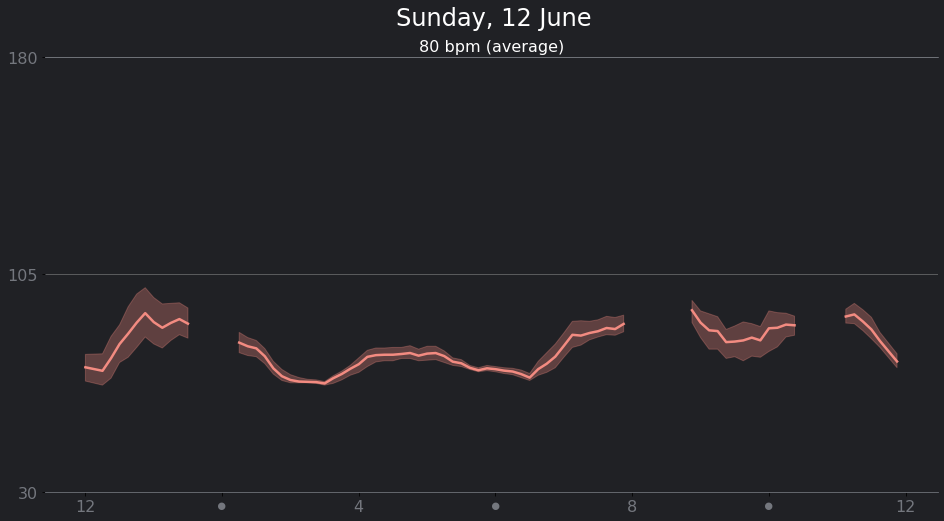

In [ ]:
# Creating a matplotlib plot of size 16,8
plt1 = plt.figure(figsize=(16,8), facecolor='#202125')
ax = plt1.gca()

#Setting the ylimits
plt.ylim(30,180)

#Setting x and y ticks
plt.yticks([30,105,180], color='#74777E',fontsize=16)
xticks = [hr_date+t*14400000 for t in np.arange(7)]
plt.xticks(xticks,labels=['12','⚫','4','⚫','8','⚫','12',
            '⚫','4','⚫','8','⚫','12'],color='#74777E',fontsize=16)

# Adding veritcal grids
plt.grid(axis="y",alpha=0.5)

#Smoothing out the curve
y_sf = savgol_filter((list(hr_plot_dict2.values())), 5, 1)

#Filling limit lines
plt.fill_between([int(tick) for tick in list(hr_plot_dict_low_high.keys())],
                 savgol_filter([np.nan if value[0]==np.nan else value[0] for
                  value in hr_plot_dict_low_high.values()],5,1),
                 savgol_filter([np.nan if value[1]==np.nan else value[1] for
                value in hr_plot_dict_low_high.values()],5,1),color='#F38B81',
                 alpha=0.3)

#Setting background color
ax.set_facecolor('#202125')

#Setting the color of the x-axis
ax.spines['bottom'].set_color('#74777E')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_color('#74777E')


#Creating the plot
plt.plot([int(tick) for tick in list(hr_plot_dict2.keys())],y_sf,
         color='#F38B81',lw=2.5)

plt.text(0.515,0.935,hr_date_string ,transform=plt1.transFigure, 
         horizontalalignment='center', fontsize=24, color='white')
plt.title(heart_rate_avg+' bpm (average)', fontsize=16, color='white')

plt.show()

#5. Data Analysis

Data isn't much without some analysis, so we're going to do some in this section.

DISCLAIMER: the analyses below may not be 100% biologically or scientifically grounded; the code is here to assist in your process, if you are interested in asking these kinds of questions.

##5.1 Analyzing correlation between Heart Rate and Number of Steps!


Maybe the average heart rate is correlated with the number of steps you take in that time interval. Let's test if this hypothesis is true. We will do so by plotting a jointplot between those two metrics and finding the correlation.

But before we get into that, let's clean the dataframes to make sure the data that we have is ready for our analysis! We will first start with our step count dataset!

In [ ]:
# Creates a pandas dataframe with the date values inside the json body
analysis_df = steps.assign(date=steps.get('bucket').apply(
    lambda x: x['startTimeMillis']))

# Adds a column for steps to our original df
analysis_df = analysis_df.assign(steps = analysis_df.get('bucket').apply(
    lambda x: np.nan if len(x['dataset'][0]['point'])==0 else
     x['dataset'][0]['point'][0]['value'][0]['intVal']))

# Plotting the data frame for reference 
analysis_df.head()


,bucket,date,steps
0,"{'startTimeMillis': '1652659200000', 'endTimeM...",1652659200000,18633
1,"{'startTimeMillis': '1652745600000', 'endTimeM...",1652745600000,12758
2,"{'startTimeMillis': '1652832000000', 'endTimeM...",1652832000000,11090
3,"{'startTimeMillis': '1652918400000', 'endTimeM...",1652918400000,13246
4,"{'startTimeMillis': '1653004800000', 'endTimeM...",1653004800000,13051


Now that we have our step count, we will repeat the process for our heart rate values and drop all the pairs where either of the values are Null (NaN).

In [ ]:
# Creates a pandas dataframe with the date values inside the json body
heart_rate = heart_rate.assign(date=heart_rate.get('bucket').apply(
    lambda x: x['startTimeMillis']))

# Creates a pandas dataframe with the heart rate values inside the json body
heart_rate = heart_rate.assign(heart_rate=heart_rate.get('bucket').apply(
    lambda x: np.nan if len(x['dataset'][0]['point'])==0 else 
    x['dataset'][0]['point'][0]['value'][0]['fpVal']))

# Merging our step and heart rate datasets
analysis_df = analysis_df.merge(heart_rate, on='date')

# Dropping useless columns
analysis_df.drop(columns=['bucket_x','bucket_y'],inplace=True)

# Dropping all pairs of null values
analysis_df_cleaned = analysis_df.dropna()

# Replotting the dataframe for reference
analysis_df_cleaned

,date,steps,heart_rate
0,1652659200000,18633,89.769157
1,1652745600000,12758,94.954825
2,1652832000000,11090,88.238903
3,1652918400000,13246,91.480209
4,1653004800000,13051,74.489754
5,1653091200000,21443,94.566438
6,1653177600000,14787,96.673788
7,1653264000000,11551,78.837029
8,1653350400000,14537,90.181782
9,1653436800000,4613,82.718568


Now that we have all our required values, let's create a plot to see if there is a correlation between heart rate and steps

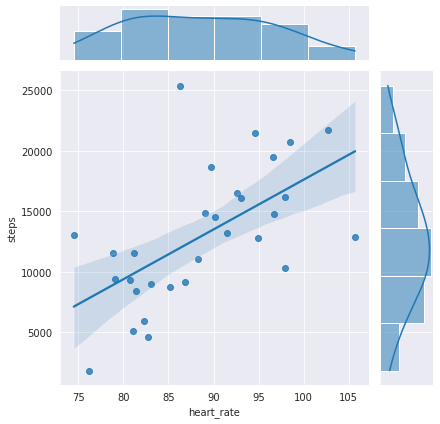

In [ ]:

# Setting Seaborn plot style
sns.set_style("darkgrid")

#Plotting our data
plot = sns.jointplot(x='heart_rate', y='steps', data=analysis_df_cleaned,
                    kind='reg')


As we can see from the scatterplot above, it looks like there might be a correlation there. Let's compute $R^2$ just to see exactly how correlated.

We'll follow [this documentation](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.linregress.html) and perform a linear regression to obtain the coefficient of determination ($R^2$).

In [ ]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(
      analysis_df_cleaned.get('heart_rate'), analysis_df_cleaned.get('steps'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: 411
Coefficient of determination: 0.361
p-value: 0.000451


As the p value is less than 0.4%, it means that that our result is statistically significant which means there is enough evidence to conclude that there is a correlation between average heart rate and the total number of steps in a day.

##5.2 Outlier Detection!


However, even though our p value seems to provide enough statistical significance that there is a correlation between average heart rate and the number of steps in a day, there might be outliers that do not follow this correlation. In this section of our analysis, we will find if there are outliers like that and if they exist, we will visually highlight them in our plot.

Before finding the individual outlier values, it would be interesting to see the summary of our step count and average heart rate parameters. It will give us a clear idea of what values are typical and which values can be considered atypical based on the data that we recieved from Google Fit.

In [ ]:
analysis_df_cleaned_summary = analysis_df_cleaned.describe().get(
                                          ['steps','heart_rate'])
analysis_df_cleaned_summary

,steps,heart_rate
count,30.000000,30.000000
mean,12948.066667,88.648472
std,5557.252962,8.117047
min,1839.000000,74.489754
25%,9200.500000,81.565956
50%,12828.000000,88.659888
75%,16182.250000,94.857728
max,25391.000000,105.713722


To locate the outliers we will be using a supervised as well as unsupervised algorithm called the Elliptic Envelope. In statistical studies, Elliptic Envelope created an imaginary elliptical area around a given dataset where values inside that imaginary area is considered to be normal data, and anything else is assumed to be outliers. It assumes that the given data follows a gaussian distribution.

"The main idea is to define the shape of the data and anomalies are those observations that lie far outside the shape. First a robust estimate of covariance of data is fitted into an ellipse around the central mode. Then, the Mahalanobis distance that is obtained from this estimate is used to define the threshold for determining outliers or anomalies." [(S. Shriram and E. Sivasankar ,2019, pp. 221-225)](https://ieeexplore.ieee.org/document/9004325)

In [ ]:
# Sometimes EllipticEnvelope shows slicing based copy warnings
# The next line changes a setting that prevents the error from happening

pd.set_option('mode.chained_assignment', None)

#create the model, set the contamination as 0.02
EE_model = EllipticEnvelope(contamination = 0.02)

#implement the model on the data
outliers = EE_model.fit_predict(analysis_df_cleaned.get(
                                                    ["steps", "heart_rate"]))

#extract the labels
analysis_df_cleaned["outlier"] = copy.deepcopy(outliers)

#change the labels
# We use -1 to mark an outlier and +1 for an inliner
analysis_df_cleaned["outlier"] = analysis_df_cleaned["outlier"].apply(
                                    lambda x: str(-1) if x == -1 else str(1))

#extract the score
analysis_df_cleaned["EE_scores"] = EE_model.score_samples(
                            analysis_df_cleaned.get(["steps", "heart_rate"]))

#print the value counts for inlier and outliers
print(analysis_df_cleaned["outlier"].value_counts())

1     29
-1     1
Name: outlier, dtype: int64


Below we will replot the analysis_df_cleaned dataframe to see how the two new columns were applied to it!

In [ ]:
analysis_df_cleaned.head()

,date,steps,heart_rate,outlier,EE_scores
0,1652659200000,18633,89.769157,1,-2.902315
1,1652745600000,12758,94.954825,1,-1.520562
2,1652832000000,11090,88.238903,1,-0.201505
3,1652918400000,13246,91.480209,1,-0.229582
4,1653004800000,13051,74.489754,1,-7.682884


Now that we have labeled the outliers as -1, let's try to see which values of average heart rate and steps are being identified as outliers by our Elliptic Envelope Algorithm.

In [ ]:
outlier_df = analysis_df_cleaned[analysis_df_cleaned.get('outlier')=='-1'].get(
    ['steps','heart_rate'])
outlier_df

,steps,heart_rate
14,25391,86.300234


Sweet, now that we know that there were outliers in our dataset, let's try to visually see which pair of values are being identified as outliers using a plot. Highlighting these outliers in a bright red color will make it super easy for us to identify them in our plot.

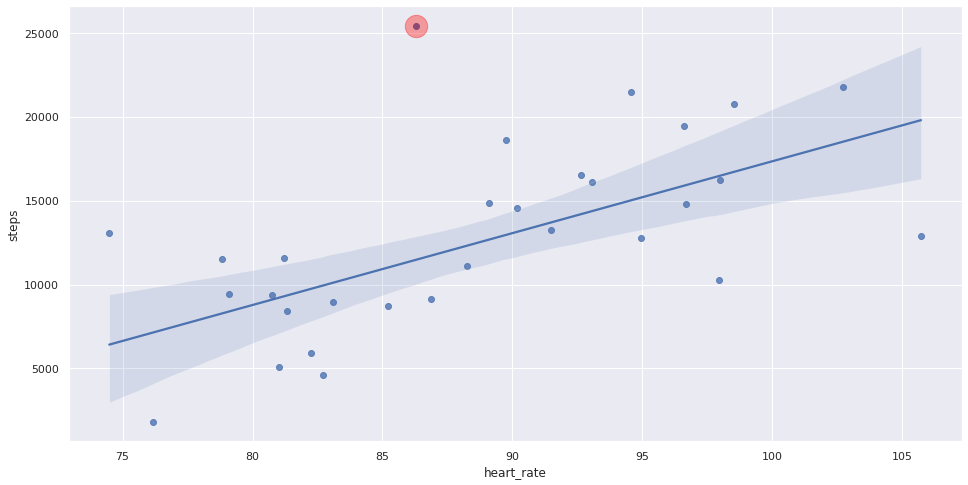

In [ ]:
# Setting Figure Size in Seaborn
sns.set(rc={'figure.figsize':(16,8)})

# Setting Seaborn plot style
sns.set_style("darkgrid")

#Plotting our data
plot = sns.regplot(x='heart_rate', y='steps', data=analysis_df_cleaned.drop(
    outlier_df.index))

plt.scatter(outlier_df.get('heart_rate'),outlier_df.get('steps'))
plt.scatter(outlier_df.get('heart_rate'),outlier_df.get('steps'),
            facecolors='red',alpha=.35, s=500)

plt.show()

Thus, the points highlighted in red are ones that seem to not be following the general trend of our dataset. Lastly, let's see what the new p-value is after outlier removal!

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    analysis_df_cleaned.drop(outlier_df.index).get('heart_rate'),
     analysis_df_cleaned.drop(outlier_df.index).get('steps'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: 428
Coefficient of determination: 0.475
p-value: 3.55e-05


Our new p-value after removing any outliers is 3.55e-05 which is much less than 5%. Therefore, after removing the outliers, our result is statistically significant which means that there is enough evidence to imply that that there is a correlation between average heart rate and the total number of steps in a day.

In [ ]:
api_url2 = "https://www.googleapis.com/fitness/v1/users/me/dataSources"
g_access_token = google_access_token
headers = {
  "Authorization": "Bearer {}".format(g_access_token),
  "Content-Type": "application/json;encoding=utf-8"
  }

response_data = requests.get(api_url2, headers=headers)
print(response_data.text)

{
  "dataSource": [
    {
      "dataStreamId": "derived:com.google.active_minutes:com.google.android.gms:merge_active_minutes",
      "dataStreamName": "merge_active_minutes",
      "type": "derived",
      "dataType": {
        "name": "com.google.active_minutes",
        "field": [
          {
            "name": "duration",
            "format": "integer"
          }
        ]
      },
      "application": {
        "packageName": "com.google.android.gms"
      },
      "dataQualityStandard": []
    },
    {
      "dataStreamId": "derived:com.google.active_minutes:com.google.ios.fit:appleinc.:iphone:702603b8:top_level",
      "dataStreamName": "top_level",
      "type": "derived",
      "dataType": {
        "name": "com.google.active_minutes",
        "field": [
          {
            "name": "duration",
            "format": "integer"
          }
        ]
      },
      "device": {
        "uid": "702603b8",
        "type": "phone",
        "model": "iphone",
        "manufactu